### Importing utils 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.constraints import non_neg

Using TensorFlow backend.


In [3]:
MOVIELENS_PATH = '/Users/patrykkowalczyk/Desktop/ml-latest-small/'
RATINGS_FILE = 'ratings.csv'
LINKS_FILE = 'links.csv'
MOVIES_FILE = 'movies.csv'
TAGS_FILE = 'tags.csv'

In [4]:
RATINGS_HEADERS = 'userId,movieId,rating,timestamp'
LINKS_HEADERS = 'movieId,imdbId,tmdbId'
MOVIES_HEADERS = 'movieId,title,genres'
TAGS_HEADERS = 'userId,movieId,tag,timestamp'

In [5]:
def get_data(movielens_path, filename, headers):
    path = movielens_path + filename
    print 'Getting data from %s' % path 
    return pd.read_csv(path, sep=',', names=headers.split(","))[1:]

def get_ratings():
    return get_data(MOVIELENS_PATH, RATINGS_FILE, RATINGS_HEADERS)

def get_links():
    return get_data(MOVIELENS_PATH, LINKS_FILE, LINKS_HEADERS)

def get_movies():
    return get_data(MOVIELENS_PATH, MOVIES_FILE, MOVIES_HEADERS)

def get_tags():
    return get_data(MOVIELENS_PATH, TAGS_FILE, TAGS_HEADERS)

### Get ratings data from file

In [6]:
ratings = get_ratings()
links = get_links()

Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/ratings.csv
Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/links.csv


In [7]:
def get_users_and_movies(dataset):
    n_users, n_movies = len(dataset.userId.unique()), len(dataset.movieId.unique())
    print 'Number of users: %d\nNumber of rated movies: %d' % (n_users, n_movies)
    return n_users, n_movies

In [8]:
merged = pd.merge(ratings, links, on='movieId', how='left')
merged = merged.loc[merged['imdbId'].notnull()]

print merged.shape
merged.head()

(100004, 6)


userId movieId rating   timestamp   imdbId tmdbId
0      1      31    2.5  1260759144  0112792   9909
1      1    1029    3.0  1260759179  0033563  11360
2      1    1061    3.0  1260759182  0117665    819
3      1    1129    2.0  1260759185  0082340   1103
4      1    1172    4.0  1260759205  0095765  11216

### Transform user IDs and movie IDs to have values from range (0, N-1)

In [10]:
merged['movieId'] = merged['imdbId']
merged.userId = merged.userId.astype('category').cat.codes.values
merged.movieId = merged.movieId.astype('category').cat.codes.values

merged.head()

userId  movieId rating   timestamp   imdbId tmdbId
0       0     3879    2.5  1260759144  0112792   9909
1       0      235    3.0  1260759179  0033563  11360
2       0     4293    3.0  1260759182  0117665    819
3       0     1898    2.0  1260759185  0082340   1103
4       0     2746    4.0  1260759205  0095765  11216

In [11]:
def fit_model(model_to_fit, train_data, epochs=10, verbose=0):
    return model_to_fit.fit([train_data.userId, train_data.movieId], train_data.rating, epochs=epochs, verbose=verbose)

def round_to_0_5(values):
    return np.round(values * 2) / 2

def predict(model, test_data, should_round=True):
    predicted = model.predict([test_data.userId, test_data.movieId])
    if should_round:
        predicted = round_to_0_5(predicted)
    return test_data.rating, predicted
    
def draw_model_fit(fitted_model):
    pd.Series(fitted_model.history['loss']).plot(logy=True)
    plt.xlabel("Epoch")
    plt.ylabel("Train Error")

def get_metrics(y_true, y_predicted):
    mean_abs_err = mae(y_true, y_predicted)
    mean_sq_err = mse(y_true, y_predicted)
    print 'Mean absolute error: %.4f\nMean squared error: %.4f' % (mean_abs_err, mean_sq_err)
    return mean_abs_err, mean_sq_err

def draw_nn_model(model):
    return SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

def summarise_nn_model(model):
    return model.summary()

In [12]:
n_users, n_movies = get_users_and_movies(merged)

Number of users: 671
Number of rated movies: 9066


**Train test split**
We'll now split our dataset of 100k ratings into train (containing 80k ratings) and test (containing 20k ratings). Given the train set, we'd like to accurately estimate the ratings in the test set.

### Using neural network

In [13]:
class DenseLayers(object):
    def __init__(self, input_layer):
        self.layers = [input_layer]
        
    def add_dense_layer(self, layer_size, name='FullyConnected', dropout=.2, activation=None):
        layer_index = len(self.layers)
        
        layer_name = name
        if name == 'FullyConnected':
            layer_name += '-%d' % layer_index
        dropout_name = '%s_Dropout' % layer_name

        preceding_layer = self.layers[-1]
        dense_layer = keras.layers.Dense(layer_size, name=layer_name, activation=activation)(preceding_layer)
        
        if dropout is not None:
            self.layers.append(keras.layers.Dropout(dropout, name=dropout_name)(dense_layer))
        else:
            self.layers.append(dense_layer)
        return self

    def add_relu_dense_layer(self, layer_size, name='FullyConnected', dropout=.2):
        return self.add_dense_layer(layer_size, name, dropout, 'relu')

    def build_model(self, users, movies, learning_rate, loss_function='mean_absolute_error'):
        adam = Adam(lr=learning_rate)
        output_layer = self.layers[-1]
        model = keras.Model([users, movies], output_layer)
        model.compile(optimizer=adam, loss=loss_function)
        return model

In [81]:
TEST_SIZE = .2
train, test = train_test_split(merged, test_size=TEST_SIZE)

In [82]:
LATENT_FACTORS_USERS = 5
LATENT_FACTORS_MOVIES = 8
LEARNING_RATE = .005
DROPOUT = .2

In [83]:
# Movie input layers
movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, LATENT_FACTORS_MOVIES, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
if DROPOUT > 0:
    movie_vec = keras.layers.Dropout(DROPOUT, name='FlattenMovies_Dropout')(movie_vec)

# User input layers
user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, LATENT_FACTORS_USERS,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
if DROPOUT > 0:
    user_vec = keras.layers.Dropout(DROPOUT, name='FlattenUsers_Dropout')(user_vec)

# Concatenation: movies + users
concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
if DROPOUT > 0:
    concat = keras.layers.Dropout(DROPOUT, name='Concat_Dropout')(concat)

model = DenseLayers(concat) \
    .add_dense_layer(150) \
    .add_dense_layer(100) \
    .add_dense_layer(50) \
    .add_relu_dense_layer(20) \
    .add_relu_dense_layer(1, 'Activation', None) \
    .build_model(user_input, movie_input, LEARNING_RATE)
    
# draw_nn_model(model)
# summarise_nn_model(model)

In [84]:
fitted_model = fit_model(model, train, 20, 1)

Epoch 1/20
80003/80003 [==============================] - 9s 110us/step - loss: 0.8429
Epoch 2/20
80003/80003 [==============================] - 8s 96us/step - loss: 0.7272
Epoch 3/20
80003/80003 [==============================] - 8s 103us/step - loss: 0.7051
Epoch 4/20
80003/80003 [==============================] - 8s 105us/step - loss: 0.6951
Epoch 5/20
80003/80003 [==============================] - 8s 96us/step - loss: 0.6889
Epoch 6/20
80003/80003 [==============================] - 9s 107us/step - loss: 0.6874
Epoch 7/20
80003/80003 [==============================] - 8s 96us/step - loss: 0.6844
Epoch 8/20
80003/80003 [==============================] - 8s 96us/step - loss: 0.6804
Epoch 9/20
80003/80003 [==============================] - 8s 102us/step - loss: 0.6793
Epoch 10/20
80003/80003 [==============================] - 8s 100us/step - loss: 0.6747
Epoch 11/20
80003/80003 [==============================] - 8s 95us/step - loss: 0.6740
Epoch 12/20
80003/80003 [=====================

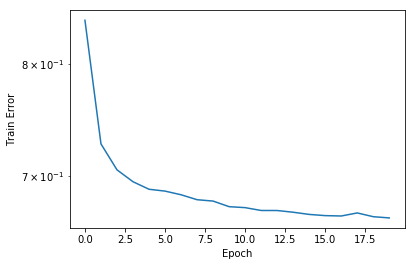

In [85]:
draw_model_fit(fitted_model)

In [90]:
y_true, y_predicted = predict(model, test)
mean_abs_err, mean_sq_err = get_metrics(y_true, y_predicted)

Mean absolute error: 0.6813
Mean squared error: 0.8599
